In [1]:
import os

import torch 
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

import zipfile
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class args:
    epoch = 10
    batch_size = 16

In [3]:
def img_resize(files,path):
    img_to_numpy = []
    for file in tqdm(files):
        file_img = Image.open(f"{path}/{file}")
        file_img = file_img.resize((256,256))
        img_to_numpy.append(np.array(file_img))
    return np.array(img_to_numpy)


In [4]:
def train_process(epoch ,model, train_data, valid_data):
    model = model.to(device)
    best_loss = float("inf")
    patience = 0
    for epoch in range(1, epoch):
        train_loss = 0
        for t_batch in train_data:
            optimizer.zero_grad()
            train_x, target_x = t_batch.to(device), t_batch.to(device)
            predicted_target = model(train_x)
            t_loss = criterion(predicted_target, target_x)
            train_loss += t_loss
            t_loss.backward()
            optimizer.step()

        with torch.no_grad():
            valid_loss = 0
            for v_batch in valid_data:
                valid_x, check_x = v_batch.to(device), v_batch.to(device)
                predicted_valid = model(valid_x)
                v_loss = criterion(predicted_valid, valid_x)
                valid_loss += v_loss
                
        if epoch % 10 == 0:
            print("Epoch:", epoch, "|", "Train Loss:", round(train_loss.item(), 4), "Valid Loss:", round(valid_loss.item(), 4))
        # 과적합 방지용 checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = 0

            last_saved_epoch = epoch
            last_saved_val_loss = best_loss
            if not os.path.exists("/kaggle/working/ckpt"):
                os.makedirs("/kaggle/working/ckpt", exist_ok=True)
            torch.save(model, os.path.join("/kaggle/working/ckpt", "ae_ckpt.pt"))
        else:
            patience += 1
        
        if patience == 50:
            break
    print("Last Chekpoint Saved Epoch:", last_saved_epoch, "|", "checkpoint saved, valid loss", round(last_saved_val_loss.item(),4))

In [5]:
def inference_img(_path, image):
    _model = torch.load(_path)
    with torch.no_grad():
        image = transforms.ToTensor()(image)
        inf_img = _model(image.to(device))
    return inf_img

In [6]:
device = "cuda" if torch.cuda.is_available else "cpu"
# device = "cpu"

In [7]:
train_data_path = "/kaggle/input/dogs-vs-cats/train.zip"
test_data_path =  "/kaggle/input/dogs-vs-cats/test1.zip"
for path in [train_data_path, test_data_path]:
    with zipfile.ZipFile(path, "r") as zip:
        zip.extractall()

In [8]:
train_files = os.listdir("/kaggle/working/train")
cat_files = sorted([file for file in train_files if file.split(".")[0] == "cat"], key=lambda x: int(x.split(".")[1]))
dog_files = sorted([file for file in train_files if file.split(".")[0] == "dog"], key=lambda x: int(x.split(".")[1]))

In [9]:
cat_random_sample = np.random.choice(cat_files, 512)
dog_random_sample = np.random.choice(dog_files, 512)

In [10]:
numpy_cat = img_resize(cat_random_sample, "/kaggle/working/train")
# cat_label = np.array([0]*len(numpy_cat))
numpy_dog = img_resize(dog_random_sample, "/kaggle/working/train")
# dog_label = np.array([1]*len(numpy_cat))

100%|██████████| 512/512 [00:01<00:00, 259.04it/s]


In [11]:
torch_cat = torch.stack([transforms.ToTensor()(cat_img) for cat_img in numpy_cat])
# torch_cat_label = torch.IntTensor(cat_label)
torch_dog = torch.stack([transforms.ToTensor()(dog_img) for dog_img in numpy_dog])
# torch_dog_label = torch.IntTensor(dog_label)

In [12]:
torch_cnd = torch.concat([torch_cat, torch_dog])
X_train, X_test = train_test_split(torch_cnd, test_size=0.2)

In [13]:
batch_train_x = DataLoader(X_train, batch_size=args.batch_size)
# batch_train_y = DataLoader(y_train, batch_size=8)
batch_valid_x = DataLoader(X_test, batch_size=args.batch_size)
# batch_valid_y = DataLoader(y_test, batch_size=8)

In [14]:
train_files = os.listdir("/kaggle/working/test1")
test_files = sorted([file for file in train_files], key=lambda x: int(x.split(".")[0]))

In [15]:
test_files_numpy = img_resize(test_files, "/kaggle/working/test1")

100%|██████████| 12500/12500 [00:46<00:00, 267.66it/s]


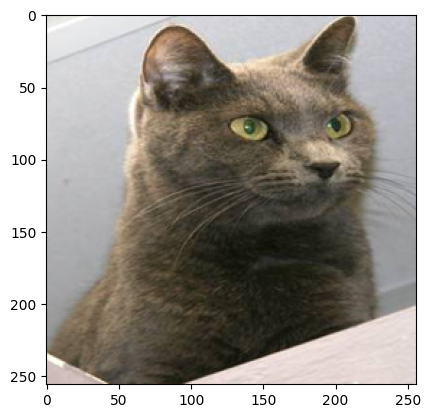

In [16]:
plt.imshow(test_files_numpy[10])

* Basic CNN

In [17]:
class AutoEncoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        
        #ENC
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2,2)
        
        #DEC
        self.dec_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0)
        self.dec_conv2 = nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0)
        
        #
        self.sigmoid = nn.Sigmoid()
    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2d(x)
        x = self.enc_conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        return x
    
    def decoder(self, x):
        x = self.dec_conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dec_conv2(x)
        x = self.dropout(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

In [18]:
model = AutoEncoder_conv().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_process(300, model, batch_train_x, batch_valid_x)

Epoch: 10 | Train Loss: 1.0057 Valid Loss: 0.2565
Epoch: 20 | Train Loss: 0.9507 Valid Loss: 0.2421
Epoch: 30 | Train Loss: 0.9381 Valid Loss: 0.2389
Epoch: 40 | Train Loss: 0.9321 Valid Loss: 0.2372
Epoch: 50 | Train Loss: 0.928 Valid Loss: 0.2362
Epoch: 60 | Train Loss: 0.9242 Valid Loss: 0.2353
Epoch: 70 | Train Loss: 0.9219 Valid Loss: 0.2347
Epoch: 80 | Train Loss: 0.92 Valid Loss: 0.2342
Epoch: 90 | Train Loss: 0.9173 Valid Loss: 0.2334
Epoch: 100 | Train Loss: 0.9118 Valid Loss: 0.2318
Epoch: 110 | Train Loss: 0.9097 Valid Loss: 0.2315
Epoch: 120 | Train Loss: 0.9087 Valid Loss: 0.2311
Epoch: 130 | Train Loss: 0.9071 Valid Loss: 0.2306
Epoch: 140 | Train Loss: 0.9055 Valid Loss: 0.2302
Epoch: 150 | Train Loss: 0.9045 Valid Loss: 0.2302
Epoch: 160 | Train Loss: 0.9042 Valid Loss: 0.2301
Epoch: 170 | Train Loss: 0.9033 Valid Loss: 0.2298
Epoch: 180 | Train Loss: 0.9026 Valid Loss: 0.2295
Epoch: 190 | Train Loss: 0.9024 Valid Loss: 0.2296
Epoch: 200 | Train Loss: 0.9018 Valid Loss:

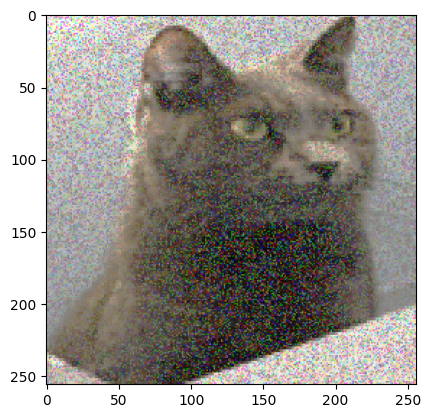

In [19]:
_path = os.path.join("/kaggle/working/ckpt", "ae_ckpt.pt")
image_recover = inference_img(_path, test_files_numpy[10])
plt.imshow(image_recover.permute(1, 2, 0).cpu().numpy())

* Conv2d layer에 채널 수 늘려서 학습
* layer: 2, max channel: 128

In [20]:
class AutoEncoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        
        #ENC
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2,2)
        
                #DEC
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.dec_conv2 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0)
        
        #
        self.sigmoid = nn.Sigmoid()
    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2d(x)
        x = self.enc_conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        return x
    
    def decoder(self, x):
        x = self.dec_conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dec_conv2(x)
        x = self.dropout(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

In [21]:
model = AutoEncoder_conv().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_process(300, model, batch_train_x, batch_valid_x)

Epoch: 10 | Train Loss: 0.8551 Valid Loss: 0.2168
Epoch: 20 | Train Loss: 0.8304 Valid Loss: 0.211
Epoch: 30 | Train Loss: 0.8209 Valid Loss: 0.2084
Epoch: 40 | Train Loss: 0.8147 Valid Loss: 0.2072
Epoch: 50 | Train Loss: 0.8108 Valid Loss: 0.2061
Epoch: 60 | Train Loss: 0.8081 Valid Loss: 0.2055
Epoch: 70 | Train Loss: 0.8061 Valid Loss: 0.2051
Epoch: 80 | Train Loss: 0.8042 Valid Loss: 0.2044
Epoch: 90 | Train Loss: 0.8018 Valid Loss: 0.2039
Epoch: 100 | Train Loss: 0.8009 Valid Loss: 0.2037
Epoch: 110 | Train Loss: 0.7997 Valid Loss: 0.2033
Epoch: 120 | Train Loss: 0.7994 Valid Loss: 0.2034
Epoch: 130 | Train Loss: 0.7993 Valid Loss: 0.203
Epoch: 140 | Train Loss: 0.7979 Valid Loss: 0.2031
Epoch: 150 | Train Loss: 0.7973 Valid Loss: 0.2026
Epoch: 160 | Train Loss: 0.7967 Valid Loss: 0.2026
Epoch: 170 | Train Loss: 0.7965 Valid Loss: 0.2026
Epoch: 180 | Train Loss: 0.7959 Valid Loss: 0.2024
Epoch: 190 | Train Loss: 0.7974 Valid Loss: 0.2025
Epoch: 200 | Train Loss: 0.7951 Valid Loss

* Conv2d 채널수를 늘리니 좀 더 선명한 이미지로 복원이 된다.

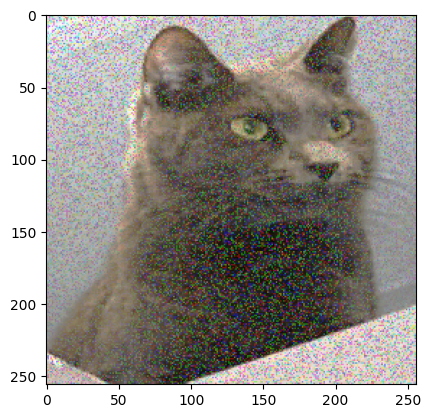

In [22]:
_path = os.path.join("/kaggle/working/ckpt", "ae_ckpt.pt")
image_recover = inference_img(_path, test_files_numpy[10])
plt.imshow(image_recover.permute(1, 2, 0).cpu().numpy())

* layer: 2, max channel: 256

In [23]:
class AutoEncoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        
        #ENC
        self.enc_conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2,2)
        
                #DEC
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.dec_conv2 = nn.ConvTranspose2d(128, 3, kernel_size=2, stride=2, padding=0)
        
        #
        self.sigmoid = nn.Sigmoid()
    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2d(x)
        x = self.enc_conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        return x
    
    def decoder(self, x):
        x = self.dec_conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dec_conv2(x)
        x = self.dropout(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

In [24]:
model = AutoEncoder_conv().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_process(300, model, batch_train_x, batch_valid_x)

Epoch: 10 | Train Loss: 0.819 Valid Loss: 0.2086
Epoch: 20 | Train Loss: 0.8005 Valid Loss: 0.2036
Epoch: 30 | Train Loss: 0.7918 Valid Loss: 0.2014
Epoch: 40 | Train Loss: 0.7898 Valid Loss: 0.2008
Epoch: 50 | Train Loss: 0.7836 Valid Loss: 0.1992
Epoch: 60 | Train Loss: 0.7826 Valid Loss: 0.1988
Epoch: 70 | Train Loss: 0.7805 Valid Loss: 0.1985
Epoch: 80 | Train Loss: 0.7788 Valid Loss: 0.1981
Epoch: 90 | Train Loss: 0.7813 Valid Loss: 0.1992
Epoch: 100 | Train Loss: 0.7768 Valid Loss: 0.1976
Epoch: 110 | Train Loss: 0.7769 Valid Loss: 0.1976
Epoch: 120 | Train Loss: 0.7757 Valid Loss: 0.1976
Epoch: 130 | Train Loss: 0.7757 Valid Loss: 0.1971
Epoch: 140 | Train Loss: 0.7756 Valid Loss: 0.1972
Epoch: 150 | Train Loss: 0.7759 Valid Loss: 0.1976
Epoch: 160 | Train Loss: 0.7751 Valid Loss: 0.1972
Epoch: 170 | Train Loss: 0.7744 Valid Loss: 0.1971
Epoch: 180 | Train Loss: 0.7731 Valid Loss: 0.1967
Epoch: 190 | Train Loss: 0.7737 Valid Loss: 0.1967
Epoch: 200 | Train Loss: 0.7761 Valid Los

* 채널수를 올릴수록 복원된 이미지가 선명해진다.

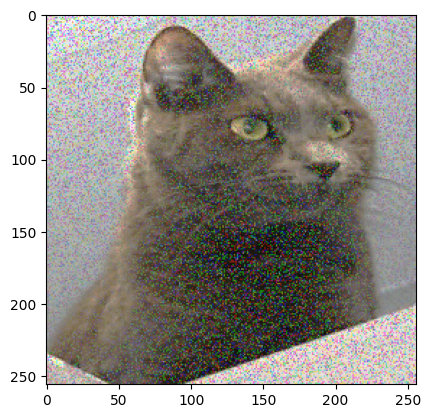

In [25]:
_path = os.path.join("/kaggle/working/ckpt", "ae_ckpt.pt")
image_recover = inference_img(_path, test_files_numpy[10])
plt.imshow(image_recover.permute(1, 2, 0).cpu().numpy())

* layer: 3, max channel: 512

In [26]:
class AutoEncoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        
        #ENC
        self.enc_conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2,2)
         
                #DEC
        self.dec_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.dec_conv3 = nn.ConvTranspose2d(128, 3, kernel_size=3, stride=1, padding=1)
        
        #
        self.sigmoid = nn.Sigmoid()
    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2d(x)
        x = self.enc_conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.enc_conv3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2d(x)
        return x
    
    def decoder(self, x):
        x = self.dec_conv1(x)
#         print(x.shape)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dec_conv2(x)
#         print(x.shape)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dec_conv3(x)
#         print(x.shape)
        x = self.dropout(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

In [27]:
model = AutoEncoder_conv().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_process(300, model, batch_train_x, batch_valid_x)

Epoch: 10 | Train Loss: 0.799 Valid Loss: 0.2046
Epoch: 20 | Train Loss: 0.7822 Valid Loss: 0.2022
Epoch: 30 | Train Loss: 0.7717 Valid Loss: 0.1979
Epoch: 40 | Train Loss: 0.7684 Valid Loss: 0.1971
Epoch: 50 | Train Loss: 0.7669 Valid Loss: 0.1946
Epoch: 60 | Train Loss: 0.7614 Valid Loss: 0.1949
Epoch: 70 | Train Loss: 0.7596 Valid Loss: 0.1932
Epoch: 80 | Train Loss: 0.759 Valid Loss: 0.1934
Epoch: 90 | Train Loss: 0.757 Valid Loss: 0.193
Epoch: 100 | Train Loss: 0.7579 Valid Loss: 0.1926
Epoch: 110 | Train Loss: 0.7571 Valid Loss: 0.1937
Epoch: 120 | Train Loss: 0.7689 Valid Loss: 0.1937
Epoch: 130 | Train Loss: 0.756 Valid Loss: 0.1957
Epoch: 140 | Train Loss: 0.7536 Valid Loss: 0.1918
Epoch: 150 | Train Loss: 0.7544 Valid Loss: 0.1945
Epoch: 160 | Train Loss: 0.7543 Valid Loss: 0.1919
Epoch: 170 | Train Loss: 0.7509 Valid Loss: 0.191
Epoch: 180 | Train Loss: 0.751 Valid Loss: 0.1918
Epoch: 190 | Train Loss: 0.7509 Valid Loss: 0.1916
Epoch: 200 | Train Loss: 0.7498 Valid Loss: 0.1

* 채널 수와 Layer 개수를 늘릴 수록 좀 더 선명한 이미지로 복원된다.

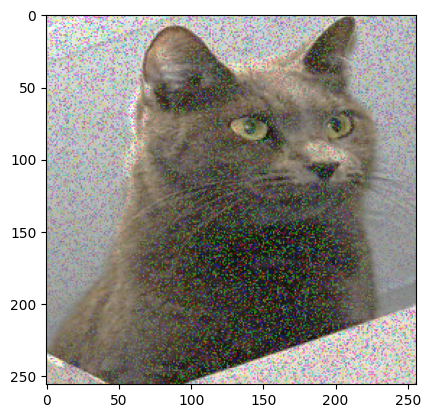

In [28]:
_path = os.path.join("/kaggle/working/ckpt", "ae_ckpt.pt")
image_recover = inference_img(_path, test_files_numpy[10])
plt.imshow(image_recover.permute(1, 2, 0).cpu().numpy())